In [218]:
import pandas as pd
import numpy as np

# Load Data

In [219]:
train = pd.read_csv("../data/Tweets Emotion Classification/train.csv")
val = pd.read_csv("../data/Tweets Emotion Classification/val.csv")
test = pd.read_csv("../data/Tweets Emotion Classification/test.csv")

In [220]:
def text_length(data):
    data['text_length'] = data['text'].apply(lambda words: len(words.split(" ")))

In [221]:
text_length(train)
text_length(val)
text_length(test)

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns

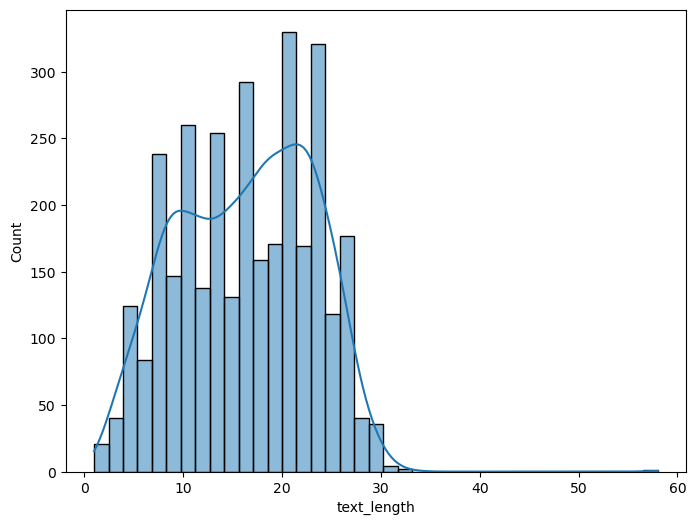

In [223]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(data=train, x='text_length', kde=True,ax=ax)
plt.savefig("../report/text_length.jpg")

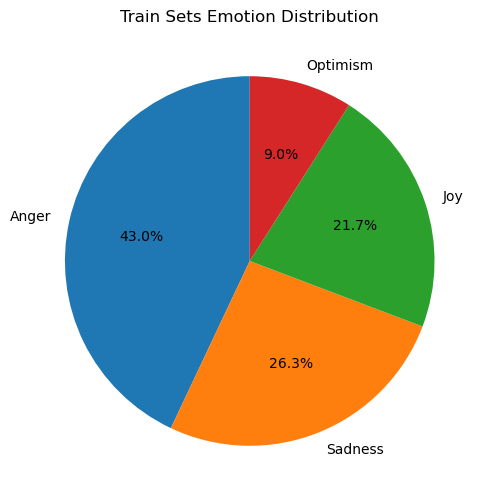

In [224]:
fig, ax = plt.subplots(figsize=(8,6))
ax.pie(train["emotion"].value_counts(),labels=train["emotion"].value_counts().index, autopct='%1.1f%%', startangle=90,)
ax.set_title(f"Train Sets Emotion Distribution")
plt.savefig("../report/Train Emotion Distribution.jpg")

In [227]:
from data_preprocessor import DataPreprocessor
from nltk.tokenize import word_tokenize

In [228]:
data_pre = DataPreprocessor()
train['processed'] = train['text'].apply(lambda x: data_pre(x))
val['processed'] = val['text'].apply(lambda x: data_pre(x))
test['processed'] = test['text'].apply(lambda x: data_pre(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yimin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [229]:
def text_processed_length(data):
    data['processed_length'] = data['processed'].apply(lambda words: len(words.split(" ")))

In [230]:
text_processed_length(train)
text_processed_length(val)
text_processed_length(test)

In [231]:
from matplotlib.ticker import MaxNLocator

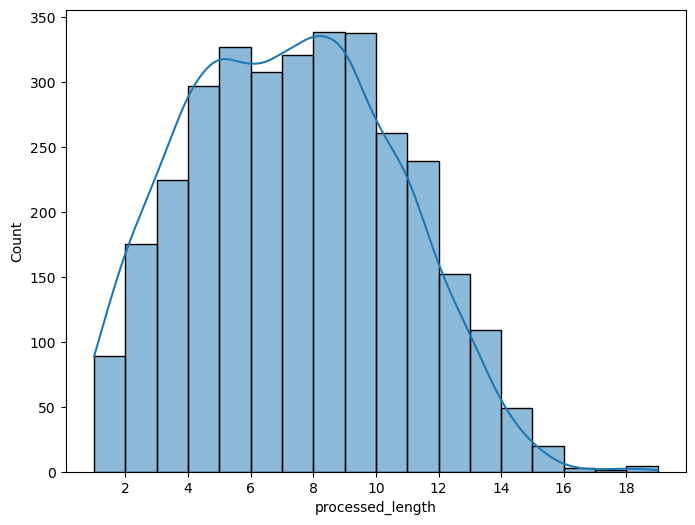

In [232]:
fig, ax = plt.subplots(figsize=(8,6))
min_data = train.processed_length.min()
max_data = train.processed_length.max()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.histplot(data=train, x='processed_length', bins=range(min_data, max_data + 1, 1), kde=True,ax=ax)
plt.savefig("../report/cleaned_text_length.jpg")

In [233]:
train.head()

,text,label,emotion,text_length,processed,processed_length
0,“Worry is a down payment on a problem you may ...,2,Optimism,18,worry payment problem may never joyce motivati...,9
1,My roommate: it's okay that we can't spell bec...,0,Anger,14,roommate okay spell terrible,4
2,No but that's so cute. Atsu was probably shy a...,1,Joy,18,cute probably shy photo cherry help,6
3,Rooneys fucking untouchable isn't he? Been fuc...,0,Anger,13,fuck untouchable fuck dreadful look decent ton...,7
4,it's pretty depressing when u hit pan on ur fa...,3,Sadness,11,pretty depress hit pan favourite highlighter,6


In [234]:
test

,text,label,emotion,text_length,processed,processed_length
0,#Deppression is real. Partners w/ #depressed p...,3,Sadness,23,real partner depress people truly understand d...,13
1,@user Interesting choice of words... Are you c...,0,Anger,19,interest choice word confirm government fund t...,11
2,My visit to hospital for care triggered #traum...,3,Sadness,24,visit hospital care trigger trauma accident ag...,13
3,@user Welcome to #MPSVT! We are delighted to h...,1,Joy,13,welcome delight grateful relationship,4
4,What makes you feel #joyful?,1,Joy,5,make feel joyful,3
...,...,...,...,...,...,...
1416,I need a sparkling bodysuit . No occasion. Jus...,1,Joy,17,need sparkle occasion case emergency sparkle suit,7
1417,@user I've finished reading it; simply mind-bl...,3,Sadness,20,finish read simply writer say continue find pa...,9
1418,shaft abrasions from panties merely shifted to...,0,Anger,11,shaft abrasion panty merely shift annoyance,6
1419,All this fake outrage. Y'all need to stop 🤣,0,Anger,9,fake outrage need stop,4


# Model

## Non Neural Network Model

In [169]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

In [170]:
tf_vectorizer = TfidfVectorizer(lowercase=False)
tf_vectorizer.fit(train['processed'])

TfidfVectorizer(lowercase=False)

In [171]:
X_train_tf = tf_vectorizer.transform(train['processed'])
X_val_tf = tf_vectorizer.transform(val['processed'])
X_test_tf = tf_vectorizer.transform(test['processed'])

In [172]:
from sklearn.naive_bayes import MultinomialNB
import pickle

In [173]:
nb_model = MultinomialNB()

In [174]:
nb_model.fit(X_train_tf,train['label'])
with open('../model/MultinomialNB.pkl', 'wb') as file:
    pickle.dump(nb_model, file)

## Deep Learning Model

In [143]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [144]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [145]:
train_text = train['processed'].tolist()
val_text = val['processed'].tolist() 
test_text = test['processed'].tolist() 

In [57]:
MAX_WORDS = 114514
tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(train_text)

In [58]:
train_seq = tokenizer.texts_to_sequences(train_text)
val_seq = tokenizer.texts_to_sequences(val_text)
test_seq = tokenizer.texts_to_sequences(test_text)
text_index = tokenizer.word_index

In [59]:
MAX_TRAIN_TEXT_LENGTH = train["processed_length"].max()
train_seq = sequence.pad_sequences(train_seq, maxlen=MAX_TRAIN_TEXT_LENGTH)
val_seq = sequence.pad_sequences(val_seq, maxlen=MAX_TRAIN_TEXT_LENGTH)
test_seq = sequence.pad_sequences(test_seq, maxlen=MAX_TRAIN_TEXT_LENGTH)

In [60]:
train_labels = np.eye(4)[train['label'].to_list()]
val_labels = np.eye(4)[val['label'].to_list()]
test_labels = np.eye(4)[test['label'].to_list()]

### Load Embedding Matrix

In [61]:
import codecs
from tqdm import tqdm

In [62]:
# code source: https://www.kaggle.com/code/vsmolyakov/keras-cnn-with-fasttext-embeddings/notebook
embeddings_index = {}
f = codecs.open('../model/crawl-300d-2M/crawl-300d-2M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

1999996it [07:37, 4367.15it/s]

found 1999996 word vectors


In [63]:
EMBEDDING_DIM = 300
WORDS_NUMBER = min(MAX_WORDS, len(text_index))

In [64]:
# code source: https://www.kaggle.com/code/vsmolyakov/keras-cnn-with-fasttext-embeddings/notebook
print('preparing embedding matrix...')
words_not_found = []
embedding_matrix = np.zeros((WORDS_NUMBER, EMBEDDING_DIM))
for word, i in text_index.items():
    if i >= WORDS_NUMBER:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 4


In [65]:
embedding_matrix = np.vstack([embedding_matrix, embedding_matrix[-1]])

In [ ]:
BATCH_SIZE = 32
NUM_EPOCHS = 50 
NUM_FILTERS = 32 
NUM_RNN_UNITS = 128
WEIGHT_DECAY = 1e-4
NUM_HEADS = 4
NUM_CLASSES = 4

In [ ]:
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, Flatten, GRU, Bidirectional,MultiHeadAttention, LSTM
from keras.layers import LeakyReLU, BatchNormalization
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.models import load_model

import json

In [ ]:
def network_classifer():
    
    input_layer = Input(shape=(MAX_TRAIN_TEXT_LENGTH,))
    
    embedding_layer = Embedding(WORDS_NUMBER+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_TRAIN_TEXT_LENGTH, trainable=False)(input_layer)
    batch_ouput = BatchNormalization()(embedding_layer)
    
    conv_output = Conv1D(NUM_FILTERS, 16, activation=LeakyReLU(alpha=0.1), padding='same')(batch_ouput)
    maxpool_output = MaxPooling1D(2)(conv_output)
    rnn_output = Bidirectional(LSTM(NUM_RNN_UNITS, return_sequences=False))(maxpool_output)
    batch_ouput = BatchNormalization()(rnn_output)
    dropout_output = Dropout(0.25)(batch_ouput)

    
    dense_output_1 = Dense(128, activation=LeakyReLU(negative_slope=0.1))(dropout_output)
    dense_output_2 = Dense(64, activation=LeakyReLU(negative_slope=0.1))(dense_output_1)
    dense_output_3 = Dense(32, activation=LeakyReLU(negative_slope=0.1))(dense_output_2)
    
    dropout_output = Dropout(0.5)(dense_output_3)
    
    output_layer = Dense(NUM_CLASSES, activation='softmax')(dropout_output)

    return Model(inputs=[input_layer], outputs=[output_layer])

In [ ]:
model = network_classifer()
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]
validation_data = (val_seq, val_labels)

In [ ]:
history = model.fit(train_seq, train_labels, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    callbacks=callbacks_list, 
                    validation_data=validation_data, 
                    shuffle=True, 
                    verbose=2)
with open('../model/deep-learning-model/classification_history.json', 'w') as f:
    json.dump(history.history, f)

In [ ]:
model.save('../model/deep-learning-model/BiLSTM.keras')

In [189]:
import json
import matplotlib.pyplot as plt

In [190]:
with open('../model/deep-learning-model/classification_history.json', 'r') as file:
    history = json.load(file)

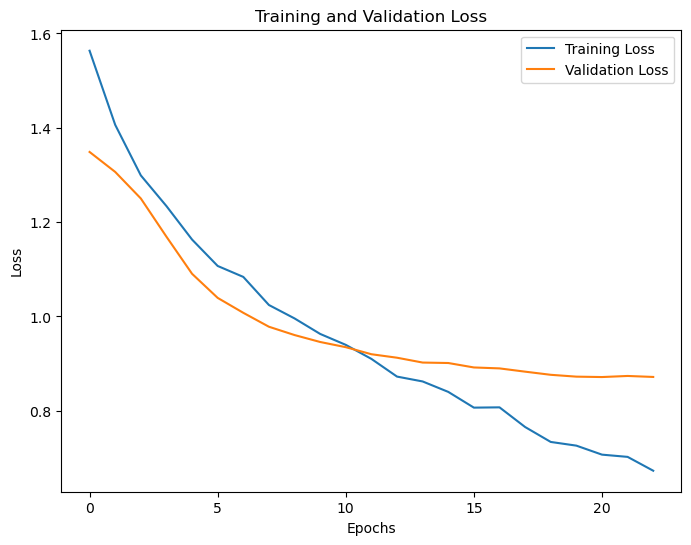

In [195]:
train_loss = history['loss']
val_loss = history['val_loss']


plt.figure(figsize=(8, 6))



plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("../report/loss.jpg")

plt.show()

# Evaluation

In [178]:
from keras.models import load_model
from tensorflow import keras
from keras.layers import LeakyReLU

In [179]:
with open('../model/MultinomialNB.pkl', 'rb') as file:
    nb_model = pickle.load(file)

In [180]:
deep_model = keras.models.load_model('../model/deep-learning-model/BiLSTM.keras',custom_objects={'LeakyReLU': LeakyReLU(negative_slope=0.01)})

In [181]:
non_deep_predict = nb_model.predict(X_test_tf)

In [182]:
deep_predict = np.argmax(deep_model.predict(test_seq), axis=1)

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


In [183]:
from sklearn.metrics import classification_report

In [184]:
non_deep_report = classification_report(test['label'], non_deep_predict)

In [185]:
print(non_deep_report)

              precision    recall  f1-score   support

           0       0.56      0.97      0.71       558
           1       0.87      0.39      0.53       358
           2       1.00      0.02      0.03       123
           3       0.71      0.55      0.62       382

    accuracy                           0.63      1421
   macro avg       0.78      0.48      0.47      1421
weighted avg       0.72      0.63      0.58      1421



In [186]:
deep_report = classification_report(test['label'], deep_predict)

In [187]:
print(deep_report)

              precision    recall  f1-score   support

           0       0.75      0.80      0.78       558
           1       0.71      0.74      0.72       358
           2       0.67      0.08      0.14       123
           3       0.62      0.72      0.67       382

    accuracy                           0.70      1421
   macro avg       0.69      0.58      0.58      1421
weighted avg       0.70      0.70      0.68      1421



In [198]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

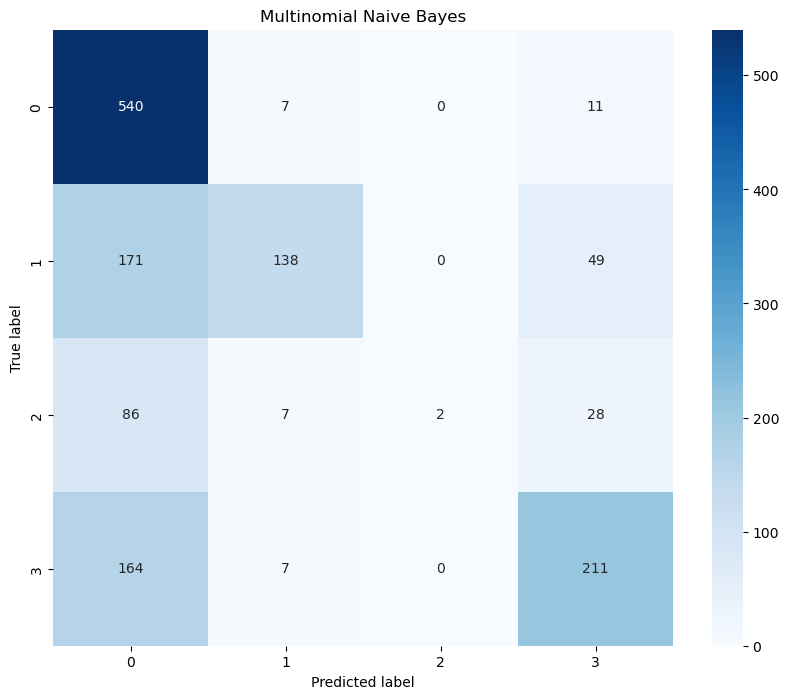

In [207]:
cm = confusion_matrix(test['label'], non_deep_predict)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title("Multinomial Naive Bayes")
plt.savefig("../report/Multinomial Naive Bayes.jpg")

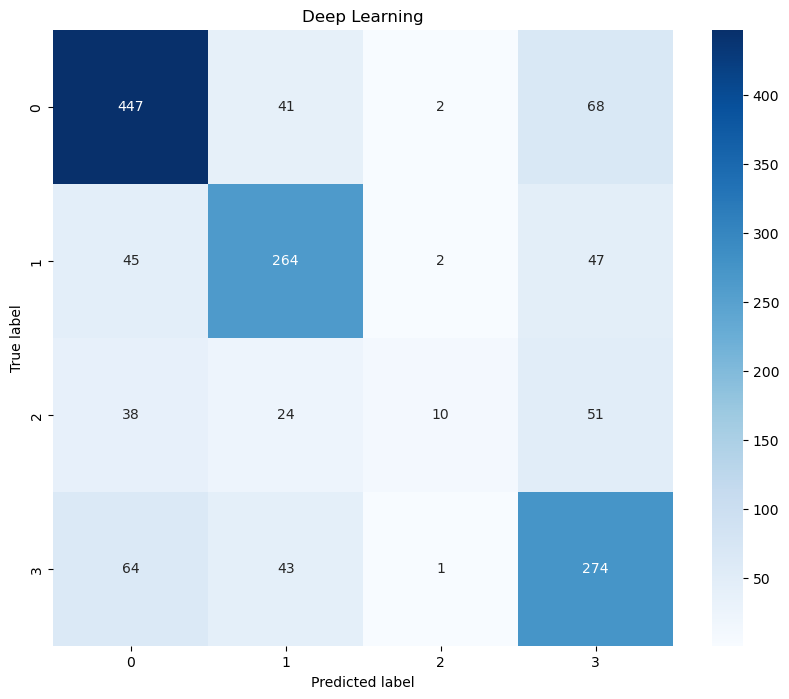

In [206]:
cm = confusion_matrix(test['label'], deep_predict)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title("Deep Learning")
plt.savefig("../report/Deep Learning.jpg")

# Topic Identification

In [379]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [380]:
positive_train_data = train[(train.emotion == 'Joy') | (train.emotion == 'Optimism')].loc[:,['label','emotion','processed']]

In [381]:
positive_train_data

,label,emotion,processed
0,2,Optimism,worry payment problem may never joyce motivati...
2,1,Joy,cute probably shy photo cherry help
7,1,Joy,tiller breezy album rap sing fire
17,2,Optimism,save order risk life panic stay calm rescue
18,2,Optimism,really horrible bad person stretch imagination...
...,...,...,...
3232,2,Optimism,accept flaw one use quote psychology depressio...
3234,1,Joy,watch amaze broadcast musically
3237,1,Joy,breezy breezy breezy breezy
3245,1,Joy,best thing see age funny miss bridget love hil...


In [382]:
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(positive_train_data.processed)

In [383]:
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

In [386]:
import pickle
with open('../model/lda_model.pkl', 'wb') as file:
    pickle.dump(lda_model, file)

In [387]:
with open('../model/lda_model.pkl', 'rb') as file:
    lda_model = pickle.load(file)

In [389]:
# Function to display topics
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict[f"Topic {topic_idx+1}"] = [feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return topic_dict
topics = display_topics(lda_model, vectorizer.get_feature_names_out(), 10)
print(topics)

{'Topic 1': ['let', 'lose', 'want', 'glee', 'think', 'take', 'love', 'smile', 'look', 'like'], 'Topic 2': ['hilarious', 'blue', 'love', 'know', 'thank', 'get', 'find', 'amp', 'best', 'breezy'], 'Topic 3': ['watch', 'amaze', 'musically', 'broadcast', 'amp', 'love', 'work', 'lively', 'get', 'start'], 'Topic 4': ['look', 'happy', 'worry', 'day', 'cheer', 'amp', 'still', 'birthday', 'every', 'need'], 'Topic 5': ['get', 'make', 'like', 'fear', 'want', 'go', 'say', 'feel', 'tell', 'little']}


In [385]:
def display_topics_with_weights(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict[f"Topic {topic_idx+1}"] = [(feature_names[i], round(topic[i], 2))
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return topic_dict

# Displaying the topics with weights
topics_with_weights = display_topics_with_weights(lda_model, vectorizer.get_feature_names_out(), 10)
print(topics_with_weights)

{'Topic 1': [('let', 21.21), ('lose', 18.2), ('want', 17.23), ('glee', 16.21), ('think', 16.04), ('take', 14.86), ('love', 13.17), ('smile', 12.97), ('look', 12.42), ('like', 12.36)], 'Topic 2': [('hilarious', 32.15), ('blue', 30.86), ('love', 30.13), ('know', 24.66), ('thank', 18.87), ('get', 17.51), ('find', 13.25), ('amp', 12.46), ('best', 12.1), ('breezy', 11.19)], 'Topic 3': [('watch', 49.4), ('amaze', 38.17), ('musically', 27.2), ('broadcast', 27.2), ('amp', 23.5), ('love', 22.08), ('work', 21.21), ('lively', 21.2), ('get', 20.97), ('start', 18.96)], 'Topic 4': [('look', 31.79), ('happy', 29.86), ('worry', 27.81), ('day', 27.12), ('cheer', 19.21), ('amp', 18.19), ('still', 17.56), ('birthday', 17.37), ('every', 15.21), ('need', 15.12)], 'Topic 5': [('get', 31.28), ('make', 21.61), ('like', 17.27), ('fear', 17.24), ('want', 16.15), ('go', 15.61), ('say', 15.41), ('feel', 14.64), ('tell', 14.15), ('little', 13.41)]}
